In [53]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
load_model_file = 'sae'
model_code = 'M1_A1'
zoomlevel = 'zoom13'
output_dim = 2
model_run_date = '22012507'
sampling = 's'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

# Load Model Embeddings

In [55]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [56]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [57]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, unique_ct)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [58]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

# MNL for Mode Share

In [59]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=True)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [60]:
wd_list = [0.00005,0.0001,0.0005,0.001]
lr_list = [0.001, 0.005, 0.01]

for (lr, wd) in itertools.product(lr_list, wd_list):
    # model setup
    model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # model training

    ref1 = 0
    ref2 = 0

    for epoch in range(400):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))

        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
        loss_ = train_kl

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                    RMSE {np.sqrt(mse_/len(testset)):.3f} \
                    {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")


    with open(out_dir+sampling+"_"+model_code+"_mode_choice.csv", "a") as f:
        f.write("%s,%s,%s,%s,%.4f,%d,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
            (model_run_date, model_type, zoomlevel, "MNL", lr, -1, wd, 
              train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
              r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.506                 RMSE 0.504                 0.199 0.415 0.151 0.140
[epoch:  0] Test KL loss: 0.492                    RMSE 0.411                     0.216 0.326 0.044 0.117
							R2 score: -0.493 -0.712 -0.414 -0.363 
[epoch: 10] Train KL loss: 0.135                 RMSE 0.224                 0.129 0.163 0.054 0.062
[epoch: 10] Test KL loss: 0.130                    RMSE 0.220                     0.129 0.158 0.040 0.072
							R2 score: 0.470 0.599 -0.169 0.487 
[epoch: 20] Train KL loss: 0.117                 RMSE 0.204                 0.117 0.148 0.052 0.056
[epoch: 20] Test KL loss: 0.122                    RMSE 0.211                     0.124 0.147 0.040 0.075
							R2 score: 0.508 0.651 -0.171 0.437 
[epoch: 30] Train KL loss: 0.110                 RMSE 0.195                 0.112 0.141 0.051 0.053
[epoch: 30] Test KL loss: 0.118                    RMSE 0.207                     0.124 0.144 0.039 0.073
							R2 score: 0.509 0.666 -0.107 0.469 
[

[epoch: 90] Train KL loss: 0.089                 RMSE 0.168                 0.096 0.120 0.049 0.046
[epoch: 90] Test KL loss: 0.107                    RMSE 0.196                     0.122 0.131 0.039 0.070
							R2 score: 0.528 0.721 -0.099 0.514 
[epoch: 100] Train KL loss: 0.087                 RMSE 0.165                 0.094 0.118 0.049 0.046
[epoch: 100] Test KL loss: 0.108                    RMSE 0.197                     0.124 0.131 0.039 0.070
							R2 score: 0.514 0.723 -0.134 0.518 
[epoch: 110] Train KL loss: 0.085                 RMSE 0.162                 0.093 0.115 0.049 0.045
[epoch: 110] Test KL loss: 0.107                    RMSE 0.197                     0.123 0.131 0.039 0.069
							R2 score: 0.515 0.725 -0.131 0.521 
[epoch: 120] Train KL loss: 0.084                 RMSE 0.161                 0.091 0.114 0.048 0.044
[epoch: 120] Test KL loss: 0.107                    RMSE 0.196                     0.123 0.131 0.040 0.069
							R2 score: 0.517 0.725 -0.146 0.522

[epoch: 100] Train KL loss: 0.087                 RMSE 0.165                 0.094 0.118 0.049 0.046
[epoch: 100] Test KL loss: 0.106                    RMSE 0.195                     0.122 0.130 0.039 0.070
							R2 score: 0.527 0.728 -0.113 0.519 
Diverging. stop.
[epoch:  0] Train KL loss: 1.380                 RMSE 0.548                 0.222 0.454 0.154 0.146
[epoch:  0] Test KL loss: 2.079                    RMSE 0.453                     0.236 0.363 0.053 0.123
							R2 score: -0.768 -1.126 -1.048 -0.501 
[epoch: 10] Train KL loss: 0.226                 RMSE 0.244                 0.147 0.154 0.077 0.091
[epoch: 10] Test KL loss: 0.359                    RMSE 0.266                     0.156 0.174 0.040 0.122
							R2 score: 0.227 0.514 -0.159 -0.463 
[epoch: 20] Train KL loss: 0.110                 RMSE 0.193                 0.109 0.139 0.055 0.053
[epoch: 20] Test KL loss: 0.119                    RMSE 0.207                     0.126 0.141 0.040 0.075
							R2 score: 0.492 0

[epoch: 30] Train KL loss: 0.356                 RMSE 0.288                 0.158 0.223 0.065 0.063
[epoch: 30] Test KL loss: 0.454                    RMSE 0.407                     0.266 0.292 0.040 0.090
							R2 score: -1.248 -0.374 -0.164 0.191 
[epoch: 40] Train KL loss: 0.167                 RMSE 0.238                 0.124 0.182 0.066 0.063
[epoch: 40] Test KL loss: 0.239                    RMSE 0.312                     0.207 0.214 0.055 0.072
							R2 score: -0.371 0.261 -1.198 0.485 
[epoch: 50] Train KL loss: 0.377                 RMSE 0.316                 0.174 0.247 0.062 0.068
[epoch: 50] Test KL loss: 0.748                    RMSE 0.537                     0.317 0.408 0.118 0.084
							R2 score: -2.211 -1.686 -9.156 0.300 
[epoch: 60] Train KL loss: 0.139                 RMSE 0.222                 0.140 0.143 0.051 0.081
[epoch: 60] Test KL loss: 0.253                    RMSE 0.321                     0.244 0.175 0.040 0.106
							R2 score: -0.900 0.509 -0.146 -0.11

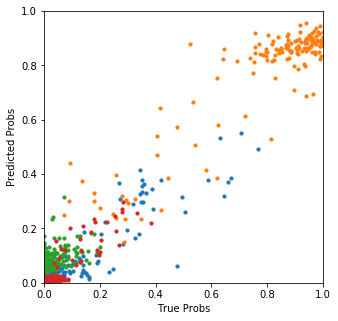

In [61]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

# LR for trip generation

In [62]:
trpgen_train =  y[~train_test_index,1]
trpgen_test =  y[train_test_index,1]

In [63]:
lr = linear_model.LinearRegression()
lr.fit(x_train, trpgen_train)
with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
    f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
        lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test), 'lr', zoomlevel,
        np.sum(lr.coef_ != 0), len(lr.coef_)))
print(lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test))

0.9999999992920083 0.6338394586288374


In [64]:
for a in np.linspace(0.005, 0.014, 10):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
        f.write("%s,%s,%s,%.6f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
            lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', zoomlevel,
            np.sum(lasso.coef_ != 0), len(lasso.coef_)))
    print(lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test))

0.5728778022482439 0.6169675750359441
0.5503212214260211 0.5951281381560225
0.5236648507049044 0.5682894503641429
0.49634690975265683 0.5403427395681156
0.47191943672004866 0.5149414192449036
0.44559977700064646 0.48677331734781715
0.41650727112071995 0.4549009282108033
0.3846463433394226 0.4193335028537325
0.35001318508944945 0.38006316247477145
0.3126112227305379 0.3370967883954815


In [65]:
for a in np.linspace(1,4,10):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
    with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
        f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
            ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
            np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

0.9345039258920709 0.7496458570594625
0.9221918023537091 0.7570908794667534
0.9121977737790844 0.7620496143734405
0.903797893353648 0.7655328952418716
0.8965583219538752 0.7680582725384554
0.8901993615528274 0.7699273495773279
0.8845309463328569 0.7713270404072865
0.8794180152603241 0.7723783558926351
0.8747615136789396 0.7731653323645468
0.870486437795585 0.7737478915434046
